# MINNEAPOLIS CRIME DATA ANALYZED WITH DEMOGRAPHIC DATA

### By Meric Birol

In this project, we analyzed Minneapolis police incident 2010 and 2018 data with census tracts by using psycopg2 which is a PostGIS library for python. The dataset we used:
> Income table (non spatial) <br>
> Total population (non spatial) <br> 
> Tracts (spatial) <br>
> Neighborhoods (spatial) <br>
> Police incident 2010 (spatial)<br>
> Police incident 2018 (spatial)

Before running some queries, tables and shapefiles are created in other platforms. <br>
> For shapefiles this command was used in "command prompt": <br>
>> shp2pgsql -s 4326 -I -W LATIN1 "C:\Users\Meric Birol\Documents\gradProject\tl_2018_27_tract\tl_2018_27_tract.shp" ctract2018 | psql -h localhost -d MericBirol -U postgres <br>

>For csv tables, first the tables were created, then used \copy function in SQL shell to upload tables: <br>
>> \copy acs_data from 'C:\Users\Meric Birol\Documents\gradProject\ACS_10_SF4_DP03\ACS_10_SF4_DP03.csv' WITH CSV HEADER;

In [1]:
#importing python libraries
import pandas as pd
import psycopg2
import geopandas as gpd
import matplotlib as plot
import pysal
import matplotlib.pyplot as plt
import mapclassify

C:\ProgramData\Anaconda3\lib\site-packages\pysal\model\spvcm\abstracts.py:10: UserWarning: The `dill` module is required to use the sqlite backend fully.
  from .sqlite import head_to_sql, start_sql


In [2]:
#database connection
try:
    conn = psycopg2.connect(dbname="MericBirol", user="postgres", password="postgres") #connects to the database with user credientials
    conn.autocommit = True
except:
    print("I am unable to connect to the database")

cur = conn.cursor() #specifies a cursor

In [ ]:
#DO NOT RUN IF THE TABLE IS ALREADY CREATED
#create table statements for nonspatial tables
cur.execute(
        """
Create table Police_Incidents_2018(
FID integer primary key,
Shape geom,
PublicAddr varchar,
ControlNbr bigint,
CCN varchar,
Precinct varchar,
ReportedDa varchar,
BeginDate varchar,
Time varchar,
Offense varchar,
Descriptio varchar,
UCRCode varchar,
EnteredDat varchar,
GBSID bigint,
Lat double precision,
Long double precision,
Neighborho varchar);

CREATE TABLE Income(
GEOid varchar,
GEOid2 varchar,
label varchar(255),
HC01_VC74 int,
HC01_VC75 int,
HC01_VC76 int,
HC01_VC77 int,
HC01_VC78 int,
HC01_VC79 int,
HC01_VC80 int,
HC01_VC81 int,
HC01_VC82 int,
HC01_VC83 int,
HC01_VC84 int,
MedianHIncome int,
MeanHIncome int);

CREATE TABLE PopulationbyTracts(
GEOid varchar,
GEOid2 varchar,
label varchar(255),
Population int);
        """)

## Choropleth Maps - Incident Density

In [ ]:
#DO NOT RUN IF THE TABLE IS ALREADY CREATED
#creates a view that shows number of incident within a census tract and its population and median household income
#in this query we used/joined income, tracts, populationbytracts, police incidents 2010 and 2018 tables. 
cur.execute('''CREATE VIEW popinccount18 AS(
WITH tractIncome AS(
SELECT t.geoid,t.geom, i.medianhincome, p.population
FROM tracts t, income i,populationbytracts p
WHERE t.geoid=i.geoid2 AND t.geoid=p.geoid2)
SELECT COUNT(p18.geom) as count18,t.geom,t.medianhincome,t.population
FROM tractIncome t, pinc2018 p18
WHERE ST_Contains(t.geom,p18.geom)
GROUP BY t.geom,t.medianhincome,t.population
ORDER BY t.medianhincome);


CREATE VIEW popinccount AS(
SELECT COUNT(p10.geom) as count10,t.count18,t.geom,t.medianhincome,t.population
FROM popinccount18 t, pinc2010 p10
WHERE ST_Contains(t.geom,p10.geom)
GROUP BY t.count18,t.geom,t.medianhincome,t.population
ORDER BY t.medianhincome)
''')

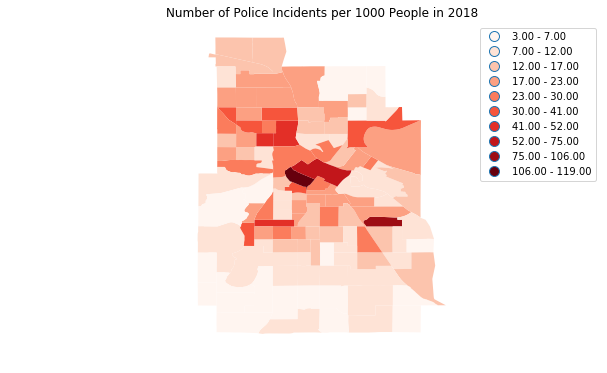

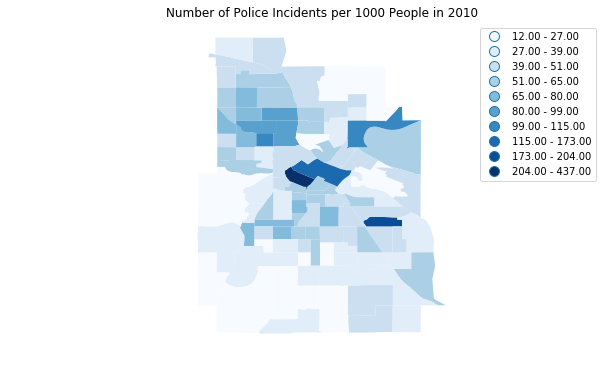

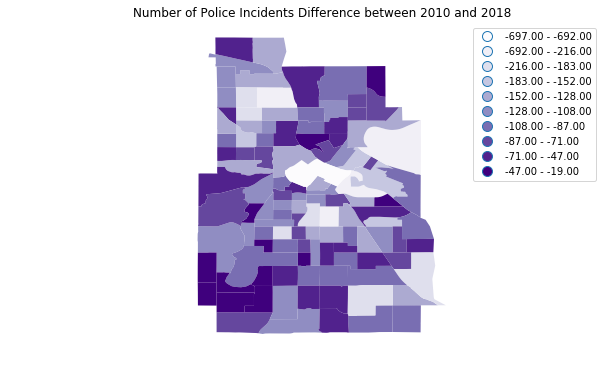

In [3]:
#map of 2018 incident density
map18 = gpd.read_postgis("SELECT (((count18)*1000)/population) AS ratio18,count18,population,geom FROM popinccount", conn, 
    geom_col='geom',coerce_float=False) #Geopandas uses PostgreSQL query which calculates the incident and population ratio
f1, ax = plt.subplots(1, figsize=(10, 6)) #specifies the figure size
ax.set_title('Number of Police Incidents per 1000 People in 2018') # map title
map18.plot(column='ratio18', scheme='fisher_jenks', k=10, cmap=plt.cm.Reds, legend=True, ax=ax) #plotting the map
ax.set_axis_off() #turns the axis off
plt.axis('equal') #streches the figure

#map of 2010 incident density
map10 = gpd.read_postgis("SELECT (((count10)*1000)/population) AS ratio10,count10,population,geom FROM popinccount", conn, 
    geom_col='geom',coerce_float=False) #Geopandas uses PostgreSQL query which calculates the incident and population ratio
f2, bx = plt.subplots(1, figsize=(10, 6)) #specifies the figure size
bx.set_title('Number of Police Incidents per 1000 People in 2010')# map title
map10.plot(column='ratio10', scheme='fisher_jenks', k=10, cmap=plt.cm.Blues, legend=True, ax=bx)#plotting the map
bx.set_axis_off() #turns the axis off
plt.axis('equal') #streches the figure

#map of the difference between 2010 and 2018 incidents
mapdiff = gpd.read_postgis("SELECT (count18-count10) as difference,population,geom FROM popinccount", conn, 
    geom_col='geom',coerce_float=False)#Geopandas uses PostgreSQL query which calculates the difference
f3, cx = plt.subplots(1, figsize=(10, 6))#specifies the figure size
cx.set_title('Number of Police Incidents Difference between 2010 and 2018')# map title
mapdiff.plot(column='difference', scheme='fisher_jenks', k=10, cmap=plt.cm.Purples, legend=True, ax=cx)#plotting the map
cx.set_axis_off() #turns the axis off
plt.axis('equal'); #streches the figure

#saves plots as png
f1.savefig('2010CrimeDensity.png')
f2.savefig('2018CrimeDensity.png')
f3.savefig('2010_2018CrimeDifference.png')

In [5]:
#saving the geopandas dataframe output as esri shapefile

map18.to_file(filename=r'C:\Users\Meric Birol\Documents\2018_crimedensity.shp', driver='ESRI Shapefile')
map10.to_file(filename=r'C:\Users\Meric Birol\Documents\2010_crimedensity.shp', driver='ESRI Shapefile')
mapdiff.to_file(filename=r'C:\Users\Meric Birol\Documents\crimedifference.shp', driver='ESRI Shapefile')


The scatter plot below, shows 2018 crime density and median household ratio. The low the median income gets, the more incident happens. The one point on the top of the plot is Downtown area. That's why it is an "outlier". 

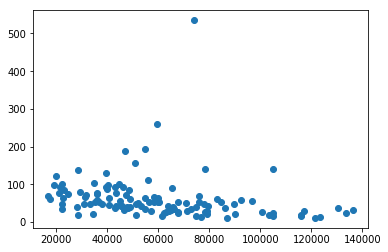

In [6]:
cur.execute('''SELECT (((count18)*1000)/population) AS ratio18,count18,population,geom,medianhincome 
            FROM popinccount''') #executes the postGIS query

#creates a Pandas dataframe from the SQL output
aaa = cur.fetchall()
col_names = []
for elt in cur.description:
    col_names.append(elt[0])
popinccountDF = pd.DataFrame(aaa, columns=col_names)

#plots a scatter plot
medInc=popinccountDF['medianhincome']
ratio18=popinccountDF['count18']
ax=plt.scatter(medInc,ratio18) #ratio of medInc,ratio18

Bar chart plotted for Offense types by Neighborhood, and later for offense type counts.

In [ ]:
#DO NOT RUN IF THE TABLE IS ALREADY CREATED
#creates a view that shows incident type counts per neighborhood
cur.execute('''CREATE VIEW incTypes as(
WITH table1 AS(
SELECT n.bdname, p.geom,p.offense,p.descriptio
FROM neighborhoods n, pinc2018 p
WHERE ST_Contains(n.geom,p.geom) )

SELECT geom,COUNT(geom),offense,descriptio,bdname
FROM table1
GROUP BY offense,geom,descriptio,bdname)
''')

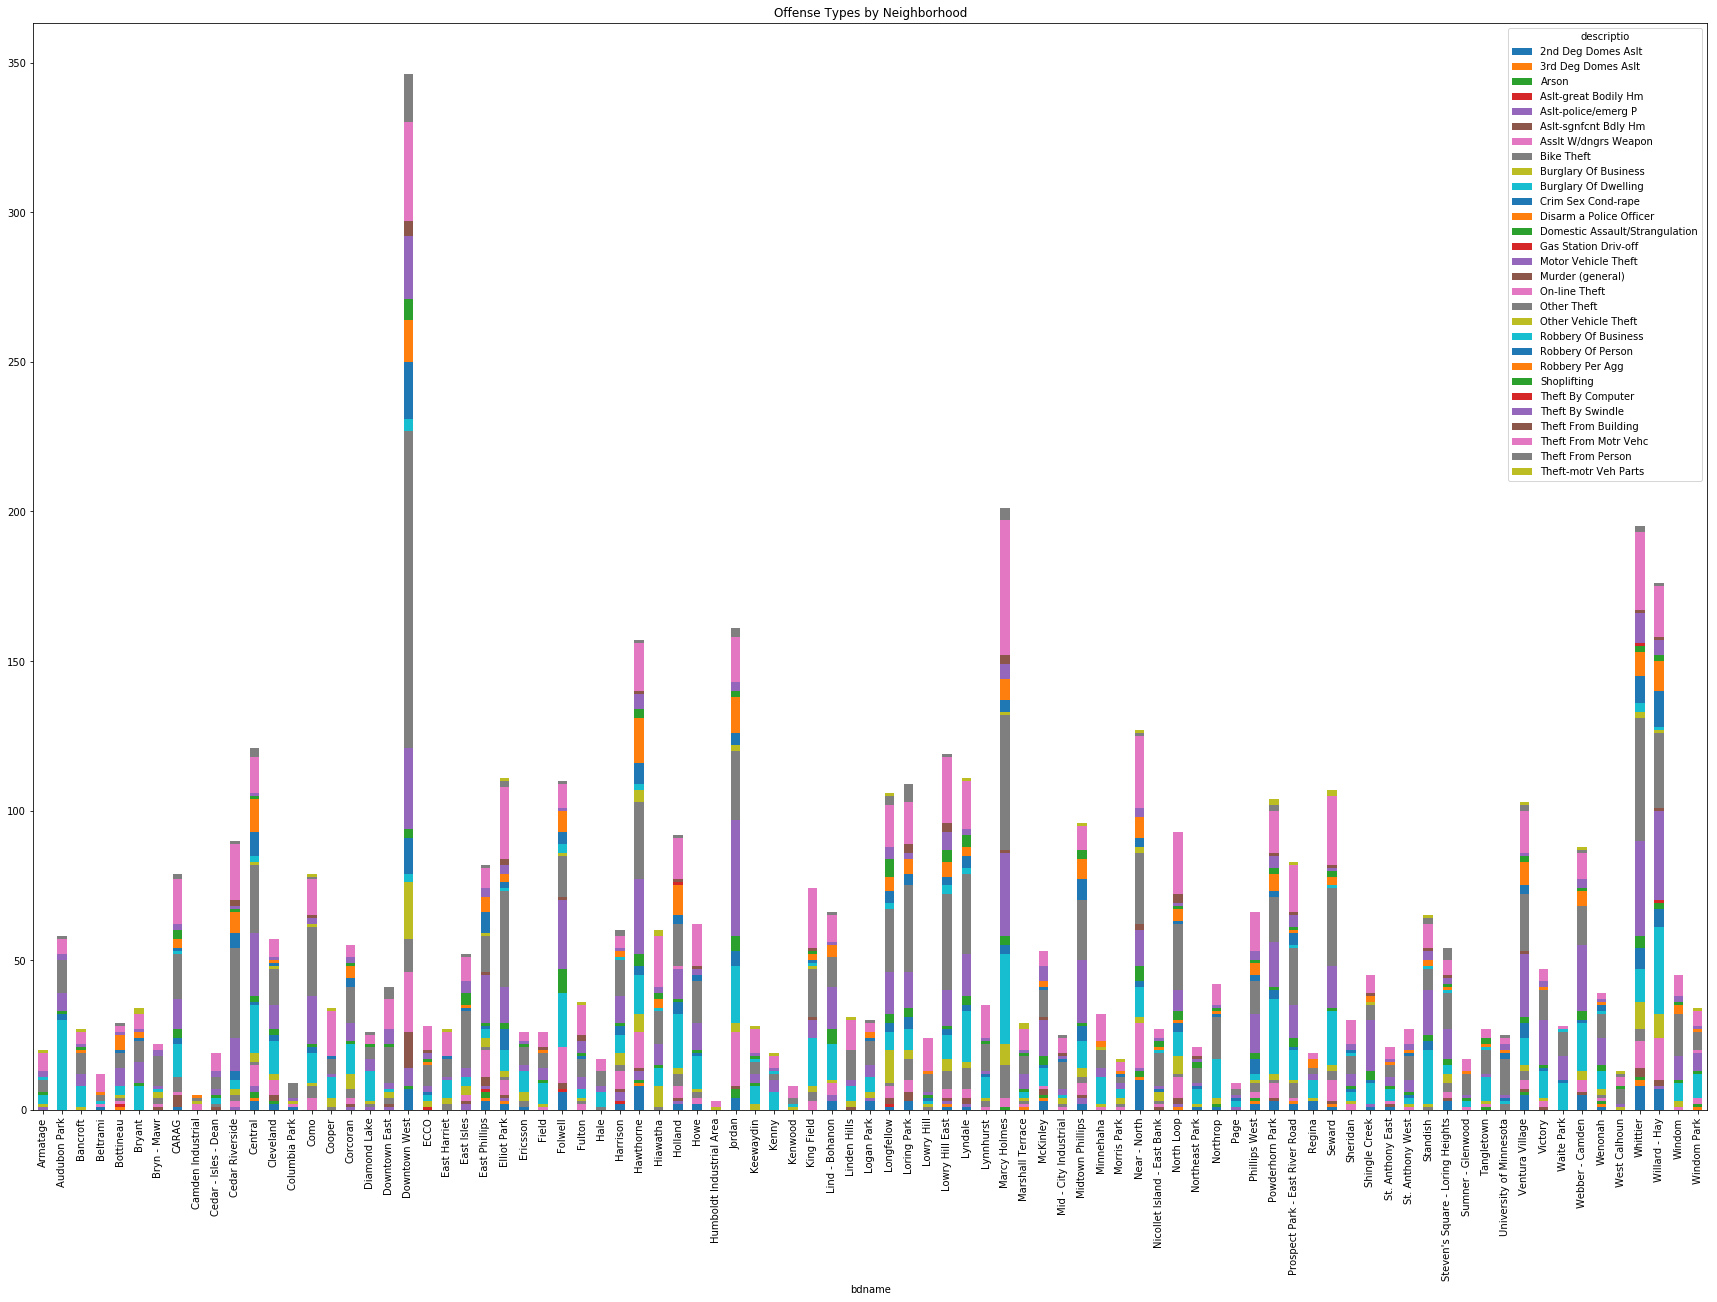

In [7]:
cur.execute('''SELECT * FROM incTypes''') #executes the PostgreSQL query
#creates a Pandas dataframe from the SQL output
aaa = cur.fetchall()
colnames = []
for i in cur.description:
    colnames.append(i[0])
incTypes = pd.DataFrame(aaa, columns=colnames)
incTypes.head() #prints the first 5 row
#draws stacked bar chart for type of incidents in the neighborhoods
incTypesplot = incTypes.groupby(['bdname', 'descriptio'])['descriptio'].count().unstack('descriptio').fillna(0) #counts the number of offense types
ax=incTypesplot.plot(kind='bar', stacked=True, figsize=(30, 20), title='Offense Types by Neighborhood') #draws the plot
fig = ax.get_figure()
fig.savefig("incTypes.png") #saves the plot

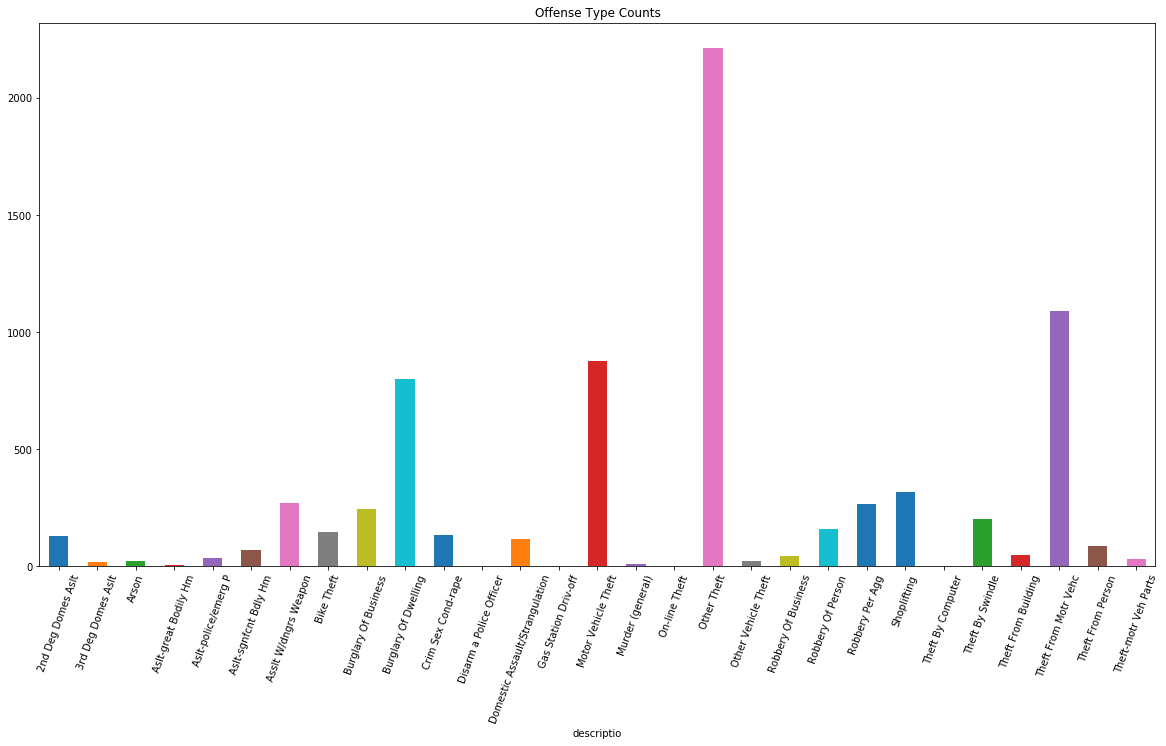

In [8]:
cur.execute('''SELECT * FROM pinc2018''') #executes the PostgreSQL query

#creates a Pandas dataframe from the SQL output
aaa = cur.fetchall()
colnames = []
for i in cur.description:
    colnames.append(i[0])
pinc2018 = pd.DataFrame(aaa, columns=colnames)

#counts the number of offense types
pinc2018count = pinc2018.groupby(['descriptio'])['descriptio'].count().fillna(0)
pinc2018count.plot.bar(figsize=(20, 10),rot=70,title='Offense Type Counts') #plots the data with rotated labels

##  Number of Incidents per Weekdays

Here we create a Pandas dataframe that has weekdays and number of incidents per each "weekday name". Then, we create a bar chart that shows the counted numbers. 

In [9]:
# A PostgreSQL query is executed here to select rows of counted incidents per weekday.
# the LEFT(begindate, 10) function in the SQL query extracts the first 10 characters from the field 
# and creates a new one as date. 
cur.execute('''with datetable as(
select LEFT(begindate, 10) as date
from pinc2018)
select *
from datetable
''')

#creates a Pandas dataframe from the SQL output
aaa = cur.fetchall()
colnames = []
for i in cur.description:
    colnames.append(i[0])
datetable18 = pd.DataFrame(aaa, columns=colnames)


# converts the text column date to a date type
datetable18['date'] =  pd.to_datetime(datetable18['date'],
                              format='%Y-%m-%d')
#gets the weekday names from the dates
datetable18['weekday'] = datetable18['date'].dt.weekday_name
datetable18.head() #prints the dataframe

,date,weekday
0,2018-05-23,Wednesday
1,2018-05-24,Thursday
2,2018-05-24,Thursday
3,2018-04-07,Saturday
4,2018-05-24,Thursday


In [10]:
# A PostgreSQL query is executed here to select rows of counted incidents per weekday.
# the LEFT(begindate, 10) function in the SQL query extracts the first 10 characters from the field 
# and creates a new one as date. 

cur.execute('''with datetable as(
select LEFT(begindate, 10) as date
from pinc2010)
select *
from datetable
''')

#creates a Pandas dataframe from the SQL output
aaa = cur.fetchall()
colnames = []
for i in cur.description:
    colnames.append(i[0])
datetable10 = pd.DataFrame(aaa, columns=colnames)


# converts the text column date to a date type
datetable10['date'] =  pd.to_datetime(datetable10['date'],
                              format='%Y-%m-%d')
#gets the weekday names from the dates
datetable10['weekday'] = datetable10['date'].dt.weekday_name
datetable10.head() #prints the dataframe

,date,weekday
0,2010-09-20,Monday
1,2010-09-14,Tuesday
2,2010-09-22,Wednesday
3,2010-09-21,Tuesday
4,2010-09-22,Wednesday


### Joining Count by Weekday dataframes for 2010 and 2018

We join the two datatables to make it easier to compare them. We use Pandas library for this. 

In [11]:
chart18=pd.DataFrame(datetable18.groupby(['weekday'])['weekday'].agg('count')) #group by weekday and count incidents
chart10=pd.DataFrame(datetable10.groupby(['weekday'])['weekday'].agg('count')) #group by weekday and count incidents
bla10=chart10.rename(index=str, columns={"weekday": "count10"}) #renaming counted field
bla18=chart18.rename(index=str, columns={"weekday": "count18"}) #renaming counted field
joinedcount=bla10.join(bla18, lsuffix='_caller', rsuffix='_other') #joins two dataframes
cats = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'] #category for sorting
joinedcountbyWeekdays = joinedcount.groupby(['weekday']).sum().reindex(cats) #sorts the dataframe by weekday order
joinedcountbyWeekdays #returns the output

,count10,count18
weekday,,
Monday,2843,976
Tuesday,2832,1025
Wednesday,2883,987
Thursday,2879,1067
Friday,3218,1095
Saturday,2932,1103
Sunday,2752,1097


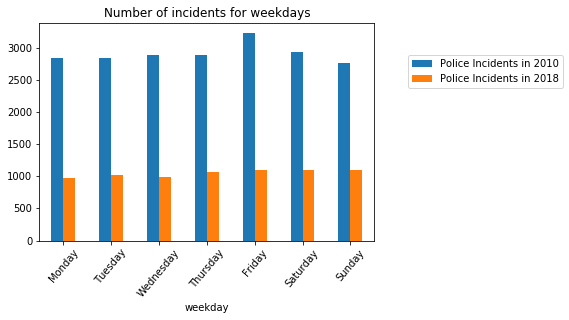

In [12]:
#plotting bar chart
ax=joinedcountbyWeekdays.plot.bar(title='Number of incidents for weekdays', rot=50) #plots the bar chart and rotates the labels
ax.legend(["Police Incidents in 2010", "Police Incidents in 2018"],loc=[1.1,.7]) #places the legend to a specific place
fig = ax.get_figure()
fig.savefig("incWeekdays.png")